<h1>Baseline Classification models</h1>

In this notebook, I'll do all the text preprocessing to our data and then I'll start with some baseline classifier models like BOW to classify the disaster tweets.  In the subsequent notebooks, I'll use more advanced methodologies to try to improve on the predictions from this model. 

<h2>Load the data</h2>

Let's first start with loading the data

In [5]:
import pandas as pd

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print('Train dataframe shape:', train.shape)
print('Test dataframe shape:', test.shape)

Train dataframe shape: (7613, 5)
Test dataframe shape: (3263, 4)


In [6]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


So, disaster tweets are labeled as 1. 

In [7]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


<h2>Text Preprocessing</h2>

Clean up the text using some basic NLP methods

In [8]:
from contractions import CONTRACTION_MAP
import re 

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
            if contraction_mapping.get(match) \
            else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("y'all I've don't I'd we're")

'you all I have do not I would we are'

In [12]:
from bs4 import BeautifulSoup
import nltk
import numpy as np
import contractions

wpt = nltk.WordPunctTokenizer()

stopwords = set(nltk.corpus.stopwords.words('english'))

def clean_text(text, expand=True):
    # strip html tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # remove URL
    text = re.sub(r'http://\S+|https?://\S+|www\.\S+', '', text)
    
    if expand:
        text = expand_contractions(text)

    # lower case, remove special characters, numbers and strip leading and trailing whitespaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    
    # remove emojis
    emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # tokenize
    tokens = wpt.tokenize(text)
    
    # filter out stopwords
    filtered_tokens = [word for word in tokens if word not in stopwords]
    
    # Join tokens
    text = ' '.join(filtered_tokens)
    return text

clean_corpus = np.vectorize(clean_text)

In [13]:
%%time
train['clean_text'] = clean_corpus(train['text'])

Wall time: 6.11 s


In [14]:
train.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


<h2>EDA</h2>

Let's visualize the data and look at some distributions to get a feel for the data and identify imbalances in our features.

<h3>Target Distribution</h3>

Let's look at the labeled train data to see what the distribution of the target feature looks like. 

Text(0.5, 1, 'Counts of Each Labeled Target')

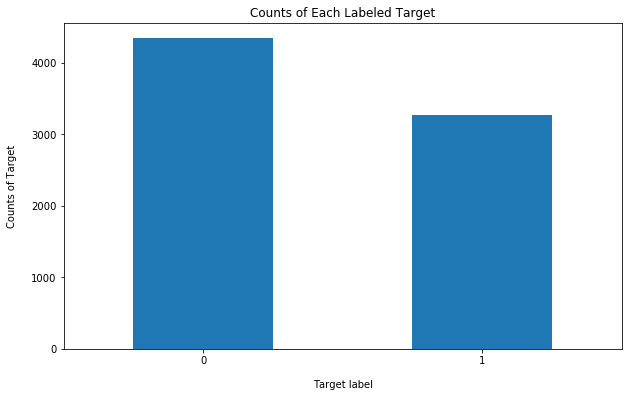

In [15]:
import matplotlib.pyplot as plt

train['target'].value_counts().plot(kind='bar', figsize=(10, 6), rot=0)
plt.xlabel('Target label', labelpad=14)
plt.ylabel('Counts of Target', labelpad=14)
plt.title('Counts of Each Labeled Target', y=1)

In [16]:
train['target'].value_counts()/len(train)

0    0.57034
1    0.42966
Name: target, dtype: float64

Roughly, 43% are disaster tweets and 57% are non-disaster tweets.  

<h3>Word distribution</h3>

Frequency of words across the tweets. We'll look at word clouds as an informal visualization and then try to get actual frequencies by unigram, bigrams and trigrams. 

In [17]:
train_0 = train[train['target']==0]
train_1 = train[train['target']==1]

<h4>Word Cloud</h4>
Let's use one of my favorite visuals -- word clouds -- to see the frequency of words in tweets per target, i.e., 0 or 1

In [18]:
from wordcloud import WordCloud

def plot_wordcloud(text, ax, clean_text=False, mask=None, max_words=200, max_font_size=100, 
                   title=None, title_size=40):

    if clean_text:
        text = clean_text(text)
    
    wordcloud = WordCloud(background_color='black',
                         stopwords = stopwords,
                         max_words = max_words,
                         max_font_size = max_font_size,
                         random_state = 0,
                         width = 800, 
                         height = 800, 
                         mask = mask)
    wordcloud.generate(text)
  
    ax.imshow(wordcloud)
    ax.axis('off')
    ax.set_title(title)

Let's see some of the most frequent words in the di

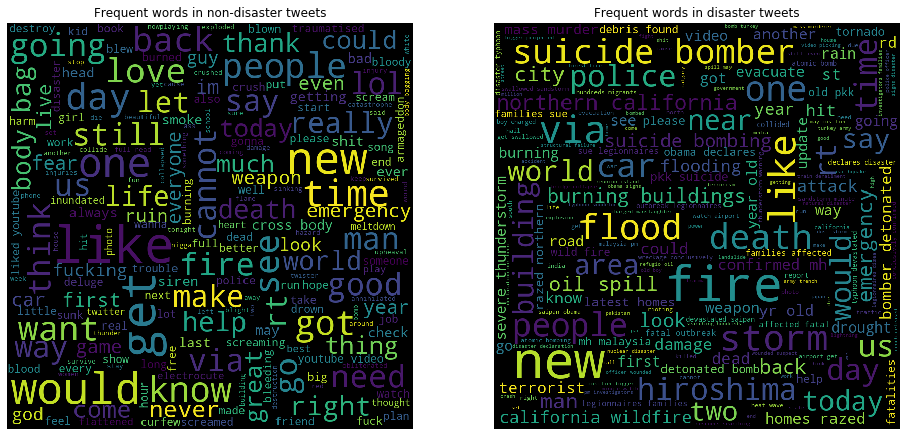

In [19]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
plot_wordcloud(' '.join(train_0['clean_text']), ax=axis1, title='Frequent words in non-disaster tweets')
plot_wordcloud(' '.join(train_1['clean_text']), ax=axis2, title='Frequent words in disaster tweets')

Wordclouds immediately show some overall differences in the frequency of words. As expected, there is a higher frequency of words like 'death', 'fire', 'suicide', 'flood' etc. in disaster tweets relative to non-disaster tweets.  But, this is obviously very informal.  Let's try to formalize this a bit and get some real numbers!

<h4>Unigram Frequencies</h4>

In [20]:
def generate_ngrams(text, n=1):
    tokens = [token for token in text.lower().split(' ') if token !='']
    ngrams = zip(*([tokens[i:] for i in range(n)]))
    return [' '.join(ngram) for ngram in ngrams]

# test ride the function
train_0['clean_text'][:10].apply(lambda x: generate_ngrams(x, n=2))

15                 []
16      [love fruits]
17    [summer lovely]
18         [car fast]
19                 []
20                 []
21      [london cool]
22      [love skiing]
23    [wonderful day]
24                 []
Name: clean_text, dtype: object

Tokenize the text and get each word's frequency

In [21]:
from collections import Counter

train_0_unigrams = generate_ngrams(' '.join(train_0['clean_text']), n=1)
train_1_unigrams = generate_ngrams(' '.join(train_1['clean_text']), n=1)

train_0_counter = pd.DataFrame(Counter(train_0_unigrams).items(), columns = ['token', 'frequency'])
train_0_counter = train_0_counter.sort_values('frequency', ascending=False)
train_1_counter = pd.DataFrame(Counter(train_1_unigrams).items(), columns = ['token', 'frequency'])
train_1_counter = train_1_counter.sort_values('frequency', ascending=False)

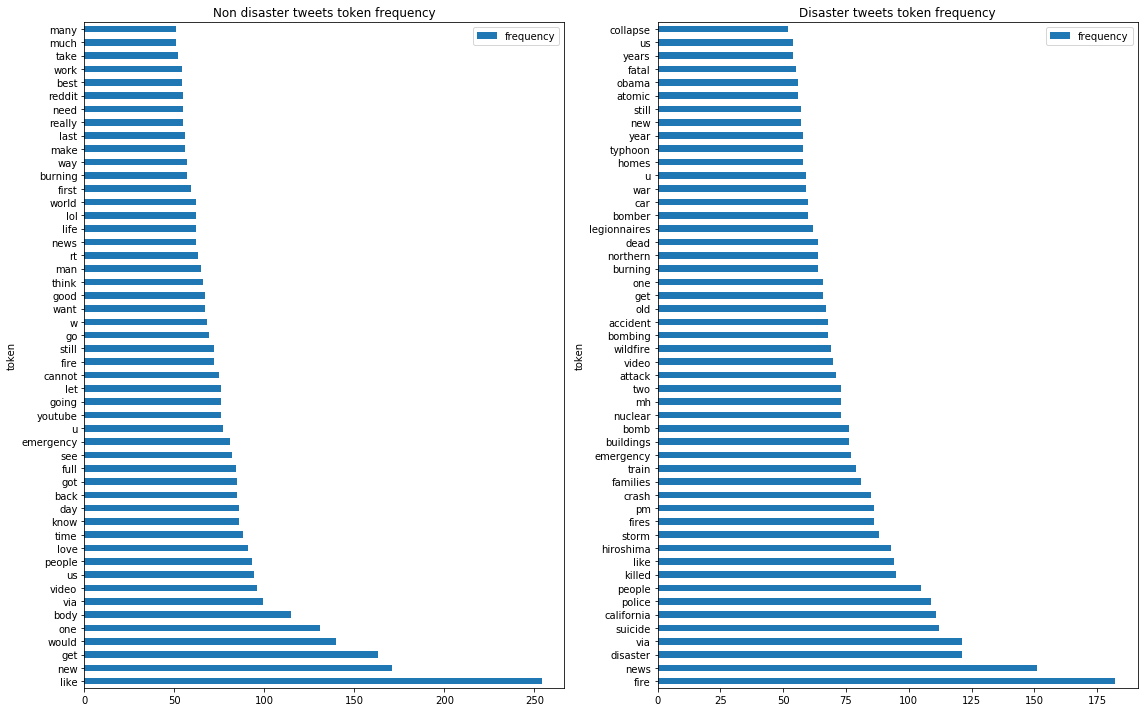

In [22]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
train_0_counter[:50].plot.barh(x='token', y='frequency', ax=axis1, title='Non disaster tweets token frequency')
train_1_counter[:50].plot.barh(x='token', y='frequency', ax=axis2, title='Disaster tweets token frequency')
fig.tight_layout()

Seems that non-disaster related tweets have a higher frequency of non-influential words, whereas disaster tweets have a higher frequency of relevant tokens like 'fire', 'disaster', 'suicide', 'storm', etc. 

<h4>Bigram Frequencies</h4>

Now, let's look at bigram frequencies.  These may be more relevant to us

In [23]:
train_0_bigrams = generate_ngrams(' '.join(train_0['clean_text']), n=2)
train_1_bigrams = generate_ngrams(' '.join(train_1['clean_text']), n=2)

train_0_counter = pd.DataFrame(Counter(train_0_bigrams).items(), columns = ['token', 'frequency'])
train_0_counter = train_0_counter.sort_values('frequency', ascending=False)
train_1_counter = pd.DataFrame(Counter(train_1_bigrams).items(), columns = ['token', 'frequency'])
train_1_counter = train_1_counter.sort_values('frequency', ascending=False)

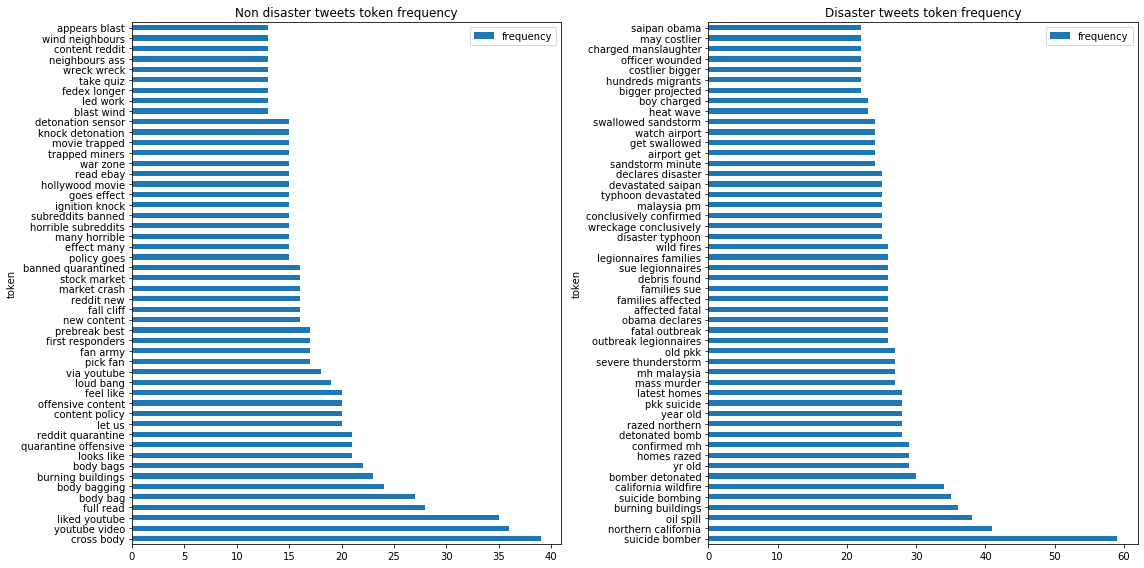

In [24]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
train_0_counter[:50].plot.barh(x='token', y='frequency', ax=axis1, title='Non disaster tweets token frequency')
train_1_counter[:50].plot.barh(x='token', y='frequency', ax=axis2, title='Disaster tweets token frequency')
fig.tight_layout()

Cool! The bigrams are definitely more informative for us humans. Not sure if bigrams would actually help when training the models since the key disaster-related words like 'suicide', 'wildfire', 'bomber', etc. are still fairly independent and predictive. Either way, let's look at trigrams, just for fun. 

<h4>Trigram frequencies</h4>

In [25]:
train_0_trigrams = generate_ngrams(' '.join(train_0['clean_text']), n=3)
train_1_trigrams = generate_ngrams(' '.join(train_1['clean_text']), n=3)

train_0_counter = pd.DataFrame(Counter(train_0_trigrams).items(), columns = ['token', 'frequency'])
train_0_counter = train_0_counter.sort_values('frequency', ascending=False)
train_1_counter = pd.DataFrame(Counter(train_1_trigrams).items(), columns = ['token', 'frequency'])
train_1_counter = train_1_counter.sort_values('frequency', ascending=False)

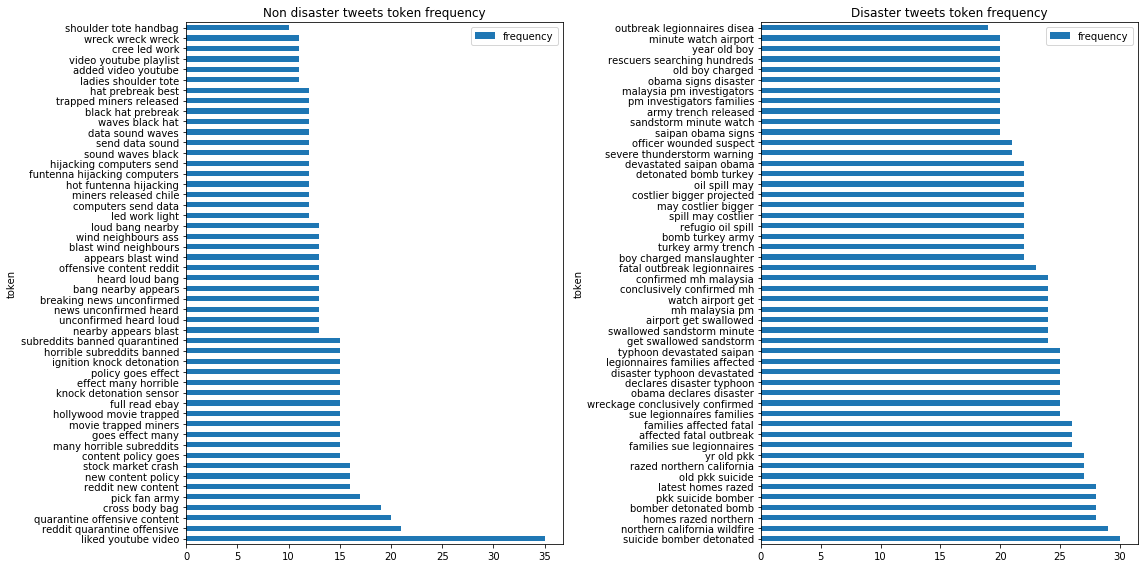

In [26]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
train_0_counter[:50].plot.barh(x='token', y='frequency', ax=axis1, title='Non disaster tweets token frequency')
train_1_counter[:50].plot.barh(x='token', y='frequency', ax=axis2, title='Disaster tweets token frequency')
fig.tight_layout()

Trigrams definitely seem extraneous. 

<h4>Meta features</h4>

I'll look at the following meta features since they might be useful features to consider in the final model:

1. Number of words in the text
2. Number of characters in the text

In [27]:
train['num_words'] = train['text'].apply(lambda x: len(x.split(' ')))
train['num_characters'] = train['text'].apply(lambda x: len(x))

In [28]:
train.head()

,id,keyword,location,text,target,clean_text,num_words,num_characters
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us,13,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,7,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,22,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...,9,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,17,88


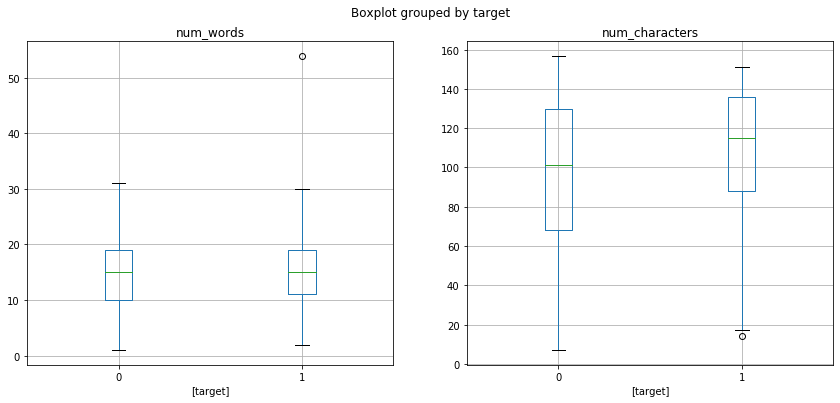

In [29]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

train.boxplot(column=['num_words'], by=['target'], ax=axis1)
train.boxplot(column=['num_characters'], by=['target'], ax=axis2)

On average, there are more characters in a disaster tweet, but not significant. 

<h4>Save the cleaned data</h4>

In [30]:
train.to_csv('data/train_cleaned.csv', index=False)

In [31]:
test['clean_text'] = clean_corpus(test['text'])
test.head()

,id,keyword,location,text,clean_text
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan


In [32]:
test.to_csv('data/test_cleaned.csv', index=False)